In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"You said you were trying out different workout routines", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Anshul"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"Whats are some best exercises for chest and triceps", name="Anshul"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

You said you were trying out different workout routines
================================ Human Message =================================
Name: Anshul

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Anshul

Whats are some best exercises for chest and triceps


In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

In [ ]:
result

AIMessage(content="For building strength and muscle in your chest and triceps, it's important to include a variety of exercises that target these muscle groups from different angles. Here are some of the best exercises for each:\n\n### Chest Exercises:\n1. **Bench Press:**\n   - This classic compound movement targets the chest, shoulders, and triceps.\n   - Variations: Flat, incline, and decline bench press can emphasize different areas of the chest.\n\n2. **Push-Ups:**\n   - A bodyweight exercise that's great for overall chest development and can be modified in several ways (e.g., incline, decline, or plyometric).\n\n3. **Dumbbell Flyes:**\n   - Helps to isolate the chest muscles more than pressing movements.\n   - Perform on a flat, incline, or decline bench.\n\n4. **Chest Dips:**\n   - Focuses on the lower part of the chest and also works the triceps.\n\n5. **Cable Crossover:**\n   - Uses cables to target the chest with constant tension throughout the movement.\n\n### Triceps Exerci

In [ ]:
result.response_metadata

{'token_usage': {'completion_tokens': 464,
  'prompt_tokens': 63,
  'total_tokens': 527,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_cbf1785567',
 'id': 'chatcmpl-CRG73rlAs5g3WxxCGy8XdqvusP22L',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

In [ ]:
from typing import Literal

def translate(
    text_to_translate: str, 
    target_language: Literal["French", "Spanish", "German"]
) -> str:
    """Translates the input text to the specified target language.

    Args:
        text_to_translate: The text that needs to be translated.
        target_language: The language to translate the text into.
    """
    
    if target_language == "French":
        return f"'{text_to_translate}' in French is 'Bonjour'."
    elif target_language == "Spanish":
        return f"'{text_to_translate}' in Spanish is 'Hola'."
    elif target_language == "German":
        return f"'{text_to_translate}' in German is 'Hallo'."
    else:
        return "Sorry, I don't know that language."

# Bind the new translation tool to the LLM
llm_with_tools = llm.bind_tools([translate])

In [ ]:
tool_call = llm_with_tools.invoke([HumanMessage(content="Whats the word for professor in french", name="Anshul")])

In [ ]:
tool_call.tool_calls

[{'name': 'translate',
  'args': {'text_to_translate': 'professor', 'target_language': 'French'},
  'id': 'call_VxXdPAajt6hTfSxzNRjfrUFW',
  'type': 'tool_call'}]

In [ ]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [ ]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [ ]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="Im looking for a list of exercises", name="Anshul")
                   ]

# New message to add
new_message = AIMessage(content="I can help with, could you be more specific", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='2a1f9c47-33a6-477b-8c22-2135bb2ec5d9'),
 HumanMessage(content='Im looking for a list of exercises', additional_kwargs={}, response_metadata={}, name='Arnav', id='15eb13fa-3ec8-4226-92c8-1faa7bd90e7d'),
 AIMessage(content='I can help with, could you be more specific', additional_kwargs={}, response_metadata={}, name='Model', id='b825f9a1-98a0-4274-a5d4-c2f1fa84aa52')]

## Our graph

Now, lets use `MessagesState` with a graph.

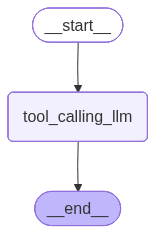

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [ ]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [ ]:
from langchain_core.messages import HumanMessage

messages = graph.invoke({"messages": [HumanMessage(content="Whats french for the word hello")]})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Whats french for the word hello
================================== Ai Message ==================================
Tool Calls:
  translate (call_fHJdVVlqtbvTzAbLdkCKPuY4)
 Call ID: call_fHJdVVlqtbvTzAbLdkCKPuY4
  Args:
    text_to_translate: hello
    target_language: French
